In [1]:
!pip install seqeval
!pip install jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=58825737ef437f831a29b86f7f2fd66be885de8499433ceaef89a8166162dae7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
# !pip freeze > requirements.txt

In [2]:
from collections import defaultdict 
from datasets import load_dataset
from datasets import Dataset
from datasets import Features,Sequence,Value, ClassLabel
import pandas as pd
from transformers import AutoTokenizer
import jsonlines
import torch
from transformers import AutoConfig
from transformers.models.roberta.modeling_roberta import RobertaForTokenClassification
from transformers import TrainingArguments
import numpy as np
from seqeval.metrics import f1_score
from transformers import Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
import matplotlib.pyplot as plt
import spacy
from spacy.tokens import Doc
from spacy.training import offsets_to_biluo_tags
from spacy.tokens import Token
from copy import deepcopy
# from torchcrf import CRF
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from transformers import set_seed
set_seed(2023)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# test = load_dataset("xtreme", name="PAN-X.de")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from typing import List, Optional

import torch
import torch.nn as nn


class CRF(nn.Module):
    """Conditional random field.

    This module implements a conditional random field [LMP01]_. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has `~CRF.decode` method which finds
    the best tag sequence given an emission score tensor using `Viterbi algorithm`_.

    Args:
        num_tags: Number of tags.
        batch_first: Whether the first dimension corresponds to the size of a minibatch.

    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.


    .. [LMP01] Lafferty, J., McCallum, A., Pereira, F. (2001).
       "Conditional random fields: Probabilistic models for segmenting and
       labeling sequence data". *Proc. 18th International Conf. on Machine
       Learning*. Morgan Kaufmann. pp. 282–289.

    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """

    def __init__(self, num_tags: int, batch_first: bool = False) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.

        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(
            self,
            emissions: torch.Tensor,
            tags: torch.LongTensor,
            mask: Optional[torch.ByteTensor] = None,
            reduction: str = 'sum',
    ) -> torch.Tensor:
        """Compute the conditional log likelihood of a sequence of tags given emission scores.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            tags (`~torch.LongTensor`): Sequence of tags tensor of size
                ``(seq_length, batch_size)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.

        Returns:
            `~torch.Tensor`: The log likelihood. This will have size ``(batch_size,)`` if
            reduction is ``none``, ``()`` otherwise.
        """
        self._validate(emissions, tags=tags, mask=mask)
        if reduction not in ('none', 'sum', 'mean', 'token_mean'):
            raise ValueError(f'invalid reduction: {reduction}')
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            tags = tags.transpose(0, 1)
            mask = mask.transpose(0, 1)

        # shape: (batch_size,)
        numerator = self._compute_score(emissions, tags, mask)
        # shape: (batch_size,)
        denominator = self._compute_normalizer(emissions, mask)
        # shape: (batch_size,)
        llh = numerator - denominator

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.type_as(emissions).sum()

    def decode(self, emissions: torch.Tensor,
               mask: Optional[torch.ByteTensor] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.

        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.

        Returns:
            List of list containing the best tag sequence for each batch.
        """
        self._validate(emissions, mask=mask)
        if mask is None:
            mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            mask = mask.transpose(0, 1)

        return self._viterbi_decode(emissions, mask)

    def _validate(
            self,
            emissions: torch.Tensor,
            tags: Optional[torch.LongTensor] = None,
            mask: Optional[torch.ByteTensor] = None) -> None:
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}')

        if tags is not None:
            if emissions.shape[:2] != tags.shape:
                raise ValueError(
                    'the first two dimensions of emissions and tags must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(tags.shape)}')

        if mask is not None:
            if emissions.shape[:2] != mask.shape:
                raise ValueError(
                    'the first two dimensions of emissions and mask must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(mask.shape)}')
            no_empty_seq = not self.batch_first and mask[0].all()
            no_empty_seq_bf = self.batch_first and mask[:, 0].all()
            if not no_empty_seq and not no_empty_seq_bf:
                raise ValueError('mask of the first timestep must all be on')

    def _compute_score(
            self, emissions: torch.Tensor, tags: torch.LongTensor,
            mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.shape[:2] == tags.shape
        assert emissions.size(2) == self.num_tags
        assert mask.shape == tags.shape
        assert mask[0].all()

        seq_length, batch_size = tags.shape
        mask = mask.type_as(emissions)
        tags = torch.tensor(np.maximum(tags.cpu().numpy(), 0)) #用datacollcator来padding时候，导致报错的原因是tags里边padding使用-100
        tags = tags.to(device)


        # Start transition score and first emission
        # shape: (batch_size,)
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            # Transition score to next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]

            # Emission score for next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        # End transition score
        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        # shape: (batch_size,)
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        # shape: (batch_size,)
        score += self.end_transitions[last_tags]

        return score

    def _compute_normalizer(
            self, emissions: torch.Tensor, mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length = emissions.size(0)

        # Start transition score and first emission; score has size of
        # (batch_size, num_tags) where for each batch, the j-th column stores
        # the score that the first timestep has tag j
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]

        for i in range(1, seq_length):
            # Broadcast score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emissions = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the sum of scores of all
            # possible tag sequences so far that end with transitioning from tag i to tag j
            # and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emissions

            # Sum over all possible current tags, but we're in score space, so a sum
            # becomes a log-sum-exp: for each sample, entry i stores the sum of scores of
            # all possible tag sequences so far, that end in tag i
            # shape: (batch_size, num_tags)
            next_score = torch.logsumexp(next_score, dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Sum (log-sum-exp) over all possible tags
        # shape: (batch_size,)
        return torch.logsumexp(score, dim=1)

    def _viterbi_decode(self, emissions: torch.FloatTensor,
                        mask: torch.ByteTensor) -> List[List[int]]:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length, batch_size = mask.shape

        # Start transition and first emission
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]
        history = []

        # score is a tensor of size (batch_size, num_tags) where for every batch,
        # value at column j stores the score of the best tag sequence so far that ends
        # with tag j
        # history saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emission = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the score of the best
            # tag sequence so far that ends with transitioning from tag i to tag j and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emission

            # Find the maximum score over all possible current tag
            # shape: (batch_size, num_tags)
            next_score, indices = next_score.max(dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # and save the index that produces the next score
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Now, compute the best path for each sample

        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list

In [4]:
#得到英语训练集 get en train_dataset
sen_list = []
spans_list = []
token_list = []
with open("/kaggle/input/train-en/sen_acc_100v2.jsonl", "r", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        if item['answer'] == 'accept':
            sen_list.append(item['text'])
            spans_list.append(item['spans'])
            tmp_list = []
            for token in item['tokens']:
                tmp_list.append(token['text'])
            token_list.append(tmp_list)

In [5]:
#得到英语测试集
sen_list_test = []
spans_list_test = []
token_list_test = []
nlp = spacy.load("en_core_web_sm")
testset = []
with open("/kaggle/input/test-200/testset_200_cyy.jsonl", "r", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        if item['answer'] == 'accept':
            sen_list_test.append(item['text'])
            spans_list_test.append(item['spans'])
            tmp_list = []
            for token in item['tokens']:
                tmp_list.append(token['text'])
            token_list_test.append(tmp_list)
for sent,spans,token_list in zip(sen_list_test,spans_list_test,token_list_test):
    doc = nlp(sent)
#     print(spans)
    offsets = [(span["token_start"], span["token_end"], span["label"]) for span in spans]
#     print(offsets)
    sen_tag = []
    for token in doc:
        token_i = token.i
#         token_start = token.idx
#         token_end = token_start + len(token)
        bio_tag = 'o'
        for offset in offsets:
            if offset[0] <= token_i and offset[1] >= token_i:
#                 print(f'token_start:{token_i}')
#                 print(f'offset[0]:{offset[0]}')
                if offset[0] == token_i:
                    bio_tag = 'B-'+ offset[2]
#                     print(token)
#                     print(bio_tag)
#                     assert 5 == 3
                    break
                else:
                    bio_tag = 'I-'+ offset[2]
                    break
#         token_list.append(token.text)
        sen_tag.append(bio_tag)
#     print(token_list)
#     print(len(sen_tag))
    assert len(token_list) == len(sen_tag)
    testset.append({'tokens': token_list, 'ner_tags': sen_tag})
# nlp = spacy.blank("en")
# testset = []
# for sen,spans,tokens in zip(sen_list_test,spans_list_test,token_list_test):
#     doc = nlp(sen)
#     offsets = [(span["start"], span["end"], span["label"]) for span in spans]
#     print(offsets)
#     assert 3==4
#     doc.ents = [doc.char_span(start, end, label) for start, end, label in offsets]
#     iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ in ["B", "I"] else t.ent_iob_ for t in doc]
#     testset.append({'tokens': tokens, 'ner_tags': iob_tags})

In [6]:
#处理英文训练集
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('sentencizer')
trainset = []

for seg,spans in zip(sen_list,spans_list):
    doc = nlp(seg)
    offsets = [(span["start"], span["end"], span["label"]) for span in spans]
#     print(offsets)
    for sent in doc.sents:
        token_list = []
        sen_tag = []
        for token in sent:
            token_start = token.idx
            token_end = token_start + len(token)
            bio_tag = 'o'
            for offset in offsets:
                if offset[0] <= token_start and offset[1] >= token_end:
#                     print(token_start)
                    if offset[0] == token_start:
                        bio_tag = 'B-'+ offset[2]
#                         print(token)
#                         print(offset[2])
#                         assert 5 == 3
                        break
                    else:
                        bio_tag = 'I-'+ offset[2]
                        break
            token_list.append(token.text)
            sen_tag.append(bio_tag)
        assert len(token_list) == len(sen_tag)
        #长度小于5的不要eg:1. 
        if len(token_list) >= 5:
            trainset.append({'tokens': token_list, 'ner_tags': sen_tag})

In [ ]:
len(trainset)

In [7]:
en_testset = []
for sen in trainset:
    labels = []
    tokens = []
    for label,token in zip(sen['ner_tags'],sen['tokens']):        
        #隐私政策中有出现空格会影响合并
        if not (token == ' ' or token == '  ' or token == '   ' or token == '    '):
            labels.append(label)
            tokens.append(token)
    en_testset.append({'tokens': tokens, 'ner_tags': labels})

In [8]:
def load_conll_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        words = []
        tags = []
        for line in f:
            if line == '\n':
                data.append({'tokens': words, 'ner_tags': tags})
                words = []
                tags = []
            else:
                word, tag = line.split('\t')
#                 print(tag)
#                 print(tag=='o\n')
                if  tag != 'o\n': 
#                     print(tag)
                    if tag.split('-')[1] == 'collect\n' or tag.split('-')[1] == 'share\n':
                        tag = 'o'
                    if tag.startswith('M') or tag.startswith('E'):
                        tag = "I-" + tag.split('-')[1]
                words.append(word)
                tags.append(tag.split("\n")[0])
    return data

In [9]:
ner = load_conll_file('/kaggle/input/ner-cn/test_all.txt')

In [10]:
#去除全o的 以及token过长的
def pre_process(dataset):
    new_ner = []
    for sen in dataset:
        all_o = False
        for label in sen['ner_tags']:
#             print(label)
            if label != 'o':
                all_o = True
        if  all_o and len(sen['tokens']) < 512:
            new_ner.append(sen)
    return new_ner
test = pre_process(ner)

In [11]:
len(test)

7568

In [ ]:
len(test)

In [11]:
ner = test

In [12]:
# feature = Features({
#     'tokens':Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
#     'ner_tags':Sequence(feature=ClassLabel(names=['o','B-handler','M-handler','E-handler','B-data','M-data','E-data','B-purpose','M-purpose','E-purpose','B-condition','M-condition','E-condition','B-subjects','M-subjects','E-subjects'], id=None), length=-1, id=None)
# })
feature = Features({
    'tokens':Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'ner_tags':Sequence(feature=ClassLabel(names=['o','B-handler','I-handler','B-data','I-data','B-purpose','I-purpose','B-condition','I-condition','B-subjects','I-subjects'], id=None), length=-1, id=None)
})

In [13]:
dataset = Dataset.from_dict({'tokens': [example['tokens'] for example in ner], 'ner_tags': [example['ner_tags'] for example in ner]},features=feature)

In [14]:
dataset_en = Dataset.from_dict({'tokens': [example['tokens'] for example in en_testset], 'ner_tags': [example['ner_tags'] for example in en_testset]},features=feature)

In [ ]:
#testset = Dataset.from_dict({'tokens': [example['tokens'] for example in testset], 'ner_tags': [example['ner_tags'] for example in testset]},features=feature)

In [ ]:
dataset

In [ ]:
#统计dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 初始化一个字典来存储每个标签的长度
label_lengths = defaultdict(list)
label_max_lengths = defaultdict(int)
# i = -1
# 遍历数据集中的每个实例
for example in test:
    ner_tags = example['ner_tags_str']
    
    # 初始化一个变量来存储当前标签的长度
    current_length = 0
#     i += 1
    # 遍历每个标签
    for tag in ner_tags:
        # 如果标签以'B-'开头或者是'O'，则将当前长度添加到对应标签的列表中，并重置当前长度
        if tag.startswith('B-')  :#or tag == 'o'
            if current_length > 0:
                label_lengths[current_label].append(current_length)
#             if current_length > 30 and current_label == 'handler':
#                 print(i)
#                 assert 3==5
            current_length = 1
            current_label = tag.split('-')[1]
        # 如果标签以'I-'开头，则增加当前长度
        elif tag.startswith('I-') and tag.split('-')[1] == current_label:
            current_length += 1
#         else: #标注中对于标点未标注为I 所以有B-o-I
#             current_length = 0
#             current_label = None
    
    # 将最后一个标签的长度添加到列表中
    if current_length > 0:
        label_lengths[current_label].append(current_length)

# 计算每个标签的平均长度
average_lengths = {label: sum(lengths)/len(lengths) for label, lengths in label_lengths.items()}

# 打印每个标签的平均长度
for label, average_length in average_lengths.items():
    print(f'{label}: {average_length}')

# # 绘制每个标签长度的小提琴图
# for label, lengths in label_lengths.items():
#     sns.violinplot(x=label, y=lengths)
# plt.show()
# 创建一个DataFrame来存储所有的长度和对应的标签
lengths = []
labels = []
for label, lengths_list in label_lengths.items():
    if label != 'o':
        lengths.extend(lengths_list)
        labels.extend([label] * len(lengths_list))

df = pd.DataFrame({
    'Label': labels,
    'Length': lengths,
})
label_order = ['handler', 'data', 'subjects', 'purpose', 'condition']

# 使用seaborn创建小提琴图
plt.figure(figsize=(10,6))
sns.boxplot(x='Label', y='Length', data=df, order=label_order)
plt.savefig('/kaggle/working/fewshot dataset statistic.svg', format='svg')
plt.show()

In [ ]:
len(test)

In [ ]:
for label, lengths in label_lengths.items():
    Max = 0
    for l in lengths:
        Max = max(l,Max)
    print(label,Max)

In [ ]:
dataset

In [15]:
# generate converter for index(int)-to-tag(string) and tag(string)-to-index(int)
tags = dataset.features["ner_tags"].feature
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

# separate dataset into train dataset and validation dataset
shuffled_dataset = dataset.shuffle(seed=2023)
dataset = shuffled_dataset.train_test_split(test_size=0.1)

In [16]:
shuffled_dataset_en = dataset_en.shuffle(seed=2023)
dataset_en = shuffled_dataset_en.train_test_split(test_size=0.19)

In [ ]:
dataset_en

In [17]:
label_names = dataset['train'].features['ner_tags']
label_names = label_names.feature.names

In [ ]:
pd.DataFrame([testset_cn[1]['tokens'], testset_cn[1]['ner_tags']],index = ['tokens','ner_tags'])

In [ ]:
# load tokenizer of pre-trained M-Bert model
# MBert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [29]:
# load tokenizer of pre-trained XML-RoBERTa model
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
# xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [20]:
def align_labels_with_tokens_en(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!遇到新词了
            current_word = word_id #当前词设为当前的word id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token若遇到的是<sep>
            new_labels.append(-100)
        else:
            # Same word as previous token 遇到子词了
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX以B打头改为以I打头
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels
def tokenize_and_align_labels_en(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
#     tokenized_inputs = MBert_tokenizer(
#         examples["tokens"], truncation=True, is_split_into_words=True
#     )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens_en(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [21]:
tokenized_datasets_en = dataset_en.map(
    tokenize_and_align_labels_en,
    batched=True,
    remove_columns=["tokens", "ner_tags"]
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
pd.DataFrame([dataset['train'][1]['tokens'],dataset['train'][1]['ner_tags']],index = ['tokens','ner_tags'])

In [ ]:
def create_tag_names(batch): 
	return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]} 
test = test.map(create_tag_names)

In [ ]:
test = deepcopy(dataset_en)

In [ ]:
dataset_en

In [ ]:
index2tag

In [22]:
def process(label_list):
    isB,isI,iso = False,False,False#flag位置为false
    for label in label_list:
        if label != 0:#not o
            if label % 2 == 1:#以B打头
                isB = True
                B_tmp = label
            if label % 2 == 0:
                isI = True
                I_tmp = label
        else:
            iso = True
    if (isB and isI) or (isB and not isI):
        return B_tmp
    if isI and not isB:
        return I_tmp
    return 0

def tokenize_and_align_labels(data):
    # 列表中的每个子列表连接成一个字符串。
    text = ["".join(t) for t in data["tokens"]]
    tokenized_inputs = xlmr_tokenizer(text, truncation=True, max_length=512)
#     tokenized_inputs = MBert_tokenizer(text, truncation=True, max_length=512)
#     tokenized_inputs = xlmr_tokenizer(text)

  #

    labels = []
    for row_idx, label_old in enumerate(data["ner_tags"]):#row_idx是原来的第几个行的索引
    # label is initialized as [[], [], [], [], [], [], []]
        label_new = [[] for t in tokenized_inputs.tokens(batch_index=row_idx)]#创建一个有n个列表的列表
    # label becomes [[1], [1], [1], [0], [5, 5], [0], [0, 0]]
    # becomes [[1], [1], [1], [0], [5, 6], [0], [6, 7]]
#         print(tokenized_inputs.tokens(batch_index=5))
        for char_idx in range(len(data["tokens"][row_idx])):#char_id是指原来原来的token列表的第几个
            token_idx = tokenized_inputs.char_to_token(row_idx, char_idx)#得到现在token位置
            if token_idx is not None:
                label_new[token_idx].append(data["ner_tags"][row_idx][char_idx])
                if (tokenized_inputs.tokens(batch_index=row_idx)[token_idx] == "▁") and (data["ner_tags"][row_idx][char_idx] != 0):#现在的token位置是_ 且这个原来的tag不为o
                    label_new[token_idx+1].append(data["ner_tags"][row_idx][char_idx])#在_位置后面那个token中加上这个tag
        # label becomes [1, 1, 1, 0, 5, 0, 0]
        #todo：在这里改把BME改动进行修改
        label_new = list(map(lambda i : process(i), label_new))
        # append result
        labels.append(label_new)
#     print(f'这是labels{labels}')
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [23]:
# run conversion
tokenized_ds = dataset.map(
  tokenize_and_align_labels,
  remove_columns=["tokens", "ner_tags"],
  batched=True,
  batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_ds

In [ ]:
pd.DataFrame(
    [xlmr_tokenizer.convert_ids_to_tokens(tokenized_ds['train'][8]['input_ids']), tokenized_ds['train'][8]['labels']],
    index=['tokens','tags'])

In [18]:
import torch.nn as nn 
from transformers import XLMRobertaConfig 
from transformers.modeling_outputs import TokenClassifierOutput 
from transformers.models.roberta.modeling_roberta import RobertaModel 
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel 

In [ ]:
import torch.nn as nn 
from transformers import BertConfig 
from transformers.modeling_outputs import TokenClassifierOutput 
from transformers.models.bert.modeling_bert import BertModel 
from transformers.models.bert.modeling_bert import BertPreTrainedModel 

class MBertForTokenClassification(BertPreTrainedModel): 
    config_class = BertConfig 
    def __init__(self, config):
        super().__init__(config) 
        self.num_labels = config.num_labels# Load model body 
        self.bert = BertModel( config, add_pooling_layer = False)
        # Set up token classification head 
        self.dropout = nn.Dropout(config.hidden_dropout_prob) 
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        #加入CRF层
        self.crf = CRF(num_tags=config.num_labels,batch_first=True)
        # Load and initialize weights 
        self.init_weights()
        
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, ** kwargs): 
        #Use model body to get encoder representations 
        outputs = self.bert(input_ids, attention_mask = attention_mask,token_type_ids = token_type_ids, ** kwargs)
    	# Apply classifier to encoder representation 
        sequence_output = self.dropout(outputs[0]) 
        logits = self.classifier(sequence_output)
    	# Calculate losses 
        loss = None
        if labels is not None:
            if attention_mask is not None:
                loss = self.crf(logits, labels, mask=attention_mask.byte())
                loss = -1 * loss
            else:
                loss = self.crf(logits, labels)
                loss = -1 * loss
        
# 		if labels is not None: 
# 			loss_fct = nn.CrossEntropyLoss() 
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))# Return model output object
        return TokenClassifierOutput(loss = loss, logits = logits, hidden_states = outputs.hidden_states, attentions = outputs.attentions)

In [19]:
#xlm-roberta+crf
class XLMRobertaForTokenClassification(RobertaPreTrainedModel): 
    config_class = XLMRobertaConfig 
    def __init__(self, config):
        super().__init__(config) 
        self.num_labels = config.num_labels# Load model body 
        self.roberta = RobertaModel( config, add_pooling_layer = False)
        # Set up token classification head 
        self.dropout = nn.Dropout(config.hidden_dropout_prob) 
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        #加入CRF层
        self.crf = CRF(num_tags=config.num_labels,batch_first=True)
        # Load and initialize weights 
        self.init_weights()
        
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, crf = True, ** kwargs): 
        #Use model body to get encoder representations 
        outputs = self.roberta(input_ids, attention_mask = attention_mask,token_type_ids = token_type_ids, ** kwargs)
    	# Apply classifier to encoder representation 
        sequence_output = self.dropout(outputs[0]) 
        logits = self.classifier(sequence_output)
    	# Calculate losses 
        loss = None
        if crf:#use crf
            if labels is not None:
                if attention_mask is not None:
                    loss = self.crf(logits, labels, mask=attention_mask.byte())
                    loss = -1 * loss
                else:
                    loss = self.crf(logits, labels)
                    loss = -1 * loss
        else:
            if labels is not None: 
                loss_fct = nn.CrossEntropyLoss() 
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))# Return model output object
        return TokenClassifierOutput(loss = loss, logits = logits, hidden_states = outputs.hidden_states, attentions = outputs.attentions)

In [ ]:
#xlm-roberta+bilstm+crf
class XLMRobertaForTokenClassification(RobertaPreTrainedModel): 
    config_class = XLMRobertaConfig 
    def __init__(self, config):
        super().__init__(config) 
        self.num_labels = config.num_labels# Load model body 
        self.roberta = RobertaModel( config, add_pooling_layer = False)
        # Set up token classification head 
        self.dropout = nn.Dropout(config.hidden_dropout_prob) 
        self.classifier = nn.Linear(1024, config.num_labels)
        self.bilstm = nn.LSTM(#LSTM层
            input_size=768,  # 1024
            hidden_size=1024 // 2,  # 1024 因为是双向LSTM，隐藏层大小为原来的一半
            batch_first=True,
            num_layers=2,
            dropout=0.5,  # 0.5 非线性
            bidirectional=True
        )
        #加入CRF层
        self.crf = CRF(num_tags=config.num_labels,batch_first=True)
        # Load and initialize weights 
        self.init_weights()
        
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, ** kwargs): 
        #Use model body to get encoder representations 
        outputs = self.roberta(input_ids, attention_mask = attention_mask,token_type_ids = token_type_ids, ** kwargs)
    	# Apply classifier to encoder representation 
        sequence_output =  self.dropout(outputs[0]) 
        lstm_output, _ = self.bilstm(sequence_output)
        logits = self.classifier(lstm_output)
    	# Calculate losses 
        loss = None
        if labels is not None:
            if attention_mask is not None:
                loss = self.crf(logits, labels, mask=attention_mask.byte())
                loss = -1 * loss
            else:
                loss = self.crf(logits, labels)
                loss = -1 * loss
        
# 		if labels is not None: 
# 			loss_fct = nn.CrossEntropyLoss() 
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))# Return model output object
        return TokenClassifierOutput(loss = loss, logits = logits, hidden_states = outputs.hidden_states, attentions =  outputs.attentions)

In [23]:
#cunstom model
#用了就不能用trainer训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_config = AutoConfig.from_pretrained(
  "xlm-roberta-base",
  num_labels=tags.num_classes,
  id2label=index2tag,
  label2id=tag2index
)

model = (XLMRobertaForTokenClassification
         .from_pretrained("xlm-roberta-base", config=xlmr_config)
         .to(device))

# xlmr_config = AutoConfig.from_pretrained(
#   "xlm-roberta-large",
#   num_labels=tags.num_classes,
#   id2label=index2tag,
#   label2id=tag2index
# )

# model = (XLMRobertaForTokenClassification
#          .from_pretrained("xlm-roberta-large", config=xlmr_config)
#          .to(device))


# mbert_config = AutoConfig.from_pretrained(
#   "bert-base-multilingual-cased",
#   num_labels=tags.num_classes,
#   id2label=index2tag,
#   label2id=tag2index
# )

# model = (MBertForTokenClassification
#          .from_pretrained("bert-base-multilingual-cased", config=mbert_config)
#          .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['crf.start_transitions', 'crf.transitions', 'classifier.weight', 'crf.end_transitions', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
#数据整理器
data_collator = DataCollatorForTokenClassification(
  xlmr_tokenizer,
  return_tensors="pt")
# data_collator = DataCollatorForTokenClassification(
#   MBert_tokenizer,
#   return_tensors="pt")

In [28]:
train_dataloader = DataLoader(tokenized_ds['train'],
                                collate_fn=data_collator,
                                batch_size=16)
eval_dataloader = DataLoader(tokenized_ds['test'],
                                collate_fn=data_collator,
                             batch_size=16)

In [29]:
#few-shot learning
indices = range(200)#40、80、120、160、200
subset = Subset(tokenized_datasets_en['train'], indices)
train_dl_en = DataLoader(subset,
                                collate_fn=data_collator,
                                batch_size=8)
eval_dl_en = DataLoader(tokenized_datasets_en['test'],
                                collate_fn=data_collator,
                             batch_size=8)

In [ ]:
len(tokenized_datasets_en['train'])

In [30]:
!pip install  evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [31]:
import evaluate
metric = evaluate.load("seqeval")
# metric.add_batch(predictions=torch.tensor(pred_seq), references=batch["labels"])

In [ ]:
def freeze_base(model):
    for param in model.roberta.parameters():
        param.requires_grad = False
    return model 
# model = freeze_base(model)

In [32]:
def compute_loss(train_losses, train_loader):
    return float(train_losses) / len(train_loader)

In [ ]:
model

In [33]:
from tqdm.auto import tqdm
import torch
from transformers import get_scheduler
from accelerate import Accelerator
from torch.optim import AdamW
lr_bert = 1e-5
lr_crf = 1e-3
crf = True
optimizer = AdamW(
        [
            {"params": model.crf.parameters()},
            {"params": model.classifier.parameters()},
            {"params": model.roberta.parameters(), "lr": lr_bert},
        ],
        lr=lr_crf,
    )#roberta+crf
# optimizer = AdamW(
#         [
#             {"params": model.crf.parameters()},
#             {"params": model.bilstm.parameters()},
#             {"params": model.classifier.parameters()},
#             {"params": model.roberta.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )#roberta+lstm+crf
# optimizer = AdamW(
#         [
#             {"params": model.crf.parameters()},
#             {"params": model.bilstm.parameters()},
#             {"params": model.classifier.parameters()},
# #             {"params": model.roberta.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )
# optimizer = AdamW(
#         [
#             {"params": model.crf.parameters()},
#             {"params": model.classifier.parameters()},
#             {"params": model.bert.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )#Mbert+crf
# optimizer = AdamW(model.parameters(), lr=2e-5)
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)
num_train_epochs = 15
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_losses = 0
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        train_losses += loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss = compute_loss(train_losses,train_dataloader)
    # Evaluation
    model.eval()
    dev_losses = 0
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        dev_losses += outputs.loss
        if crf:
            logits = outputs.logits
            predictions = model.crf.decode(logits)
            predictions = torch.tensor(predictions)
        else:
            predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)
    eval_loss = compute_loss(dev_losses,eval_dataloader)
    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
        f"train loss: {train_loss}, eval loss: {eval_loss}"
    )


  0%|          | 0/6390 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_32/1557296348.py:250: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


epoch 0: {'precision': 0.6969074182814641, 'recall': 0.6638389111587583, 'f1': 0.6799713535449987, 'accuracy': 0.8590808188769218} train loss: 524.1461267605633, eval loss: 335.62567138671875
epoch 1: {'precision': 0.7218633783519279, 'recall': 0.6977580172169142, 'f1': 0.7096060416566453, 'accuracy': 0.8689673600263093} train loss: 303.4316131161972, eval loss: 275.04941813151044
epoch 2: {'precision': 0.7331180270111568, 'recall': 0.726576139670223, 'f1': 0.7298324240062354, 'accuracy': 0.8741470032064458} train loss: 243.5585754107981, eval loss: 239.46822102864584
epoch 3: {'precision': 0.7346838911724408, 'recall': 0.7339655846695347, 'f1': 0.7343245622615672, 'accuracy': 0.8771479075885883} train loss: 206.54520613262912, eval loss: 217.6439208984375
epoch 4: {'precision': 0.7303777647289098, 'recall': 0.7299491392801252, 'f1': 0.7301633891008708, 'accuracy': 0.8745375318589164} train loss: 182.00630868544602, eval loss: 202.95589192708334
epoch 5: {'precision': 0.742513211978860

In [59]:
fewshot_model = deepcopy(model)

In [ ]:
fewshot_model = freeze_base(fewshot_model)

In [60]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [61]:
#few shot learn
lr_bert = 1e-6
lr_crf = 1e-4
optimizer = AdamW(
        [
            {"params": fewshot_model.crf.parameters()},
            {"params": fewshot_model.classifier.parameters()},
            {"params": fewshot_model.roberta.parameters(), "lr": lr_bert},
        ],
        lr=lr_crf,
    )#roberta+crf
# optimizer = AdamW(
#         [
#             {"params": fewshot_model.crf.parameters()},
#             {"params": fewshot_model.bilstm.parameters()},
#             {"params": fewshot_model.classifier.parameters()},
#             {"params": fewshot_model.roberta.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )#roberta+lstm+crf
# optimizer = AdamW(
#         [
#             {"params": fewshot_model.crf.parameters()},
#             {"params": fewshot_model.bilstm.parameters()},
#             {"params": fewshot_model.classifier.parameters()},
# #             {"params": model.roberta.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )
# optimizer = AdamW(
#         [
#             {"params": fewshot_model.crf.parameters()},
#             {"params": fewshot_model.classifier.parameters()},
#             {"params": fewshot_model.bert.parameters(), "lr": lr_bert},
#         ],
#         lr=lr_crf,
#     )#Mbert+crf
# optimizer = AdamW(model.parameters(), lr=2e-5)
accelerator = Accelerator()
fewshot_model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    fewshot_model, optimizer, train_dl_en, eval_dl_en
)
num_train_epochs = 28
num_update_steps_per_epoch = len(train_dl_en)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    fewshot_model.train()
    train_losses = 0
    for batch in train_dl_en:
        outputs = fewshot_model(**batch.to(device))
        loss = outputs.loss
        train_losses += loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss = compute_loss(train_losses,train_dl_en)
    # Evaluation
    fewshot_model.eval()
    dev_losses = 0
    for batch in eval_dl_en:
        with torch.no_grad():
            outputs = fewshot_model(**batch.to(device))
        dev_losses += outputs.loss
        logits = outputs.logits
        if crf:
            predictions = fewshot_model.crf.decode(logits)
            predictions = torch.tensor(predictions)
        else:
            predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)
    eval_loss = compute_loss(dev_losses,eval_dl_en)
    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
        f"train loss: {train_loss}, eval loss: {eval_loss}"
    )

  0%|          | 0/700 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


epoch 0: {'precision': 0.41262135922330095, 'recall': 0.4228855721393035, 'f1': 0.4176904176904177, 'accuracy': 0.786046511627907} train loss: 122.2620703125, eval loss: 79.6073506673177
epoch 1: {'precision': 0.42718446601941745, 'recall': 0.47058823529411764, 'f1': 0.44783715012722647, 'accuracy': 0.8033222591362126} train loss: 99.580478515625, eval loss: 68.70110575358073
epoch 2: {'precision': 0.42718446601941745, 'recall': 0.5, 'f1': 0.4607329842931937, 'accuracy': 0.8046511627906977} train loss: 92.057890625, eval loss: 63.94011942545573
epoch 3: {'precision': 0.42718446601941745, 'recall': 0.5, 'f1': 0.4607329842931937, 'accuracy': 0.813953488372093} train loss: 85.364345703125, eval loss: 60.55989074707031
epoch 4: {'precision': 0.44660194174757284, 'recall': 0.5111111111111111, 'f1': 0.47668393782383417, 'accuracy': 0.8232558139534883} train loss: 81.1097509765625, eval loss: 58.32612609863281
epoch 5: {'precision': 0.45145631067961167, 'recall': 0.5138121546961326, 'f1': 0.4

In [ ]:
len(eval_dataloader)

In [ ]:
results

In [20]:
from collections import Counter
import matplotlib.colors as mcolors

def flatten_lists(lists):
    flatten_list = []
    for l in lists:
        if type(l) == list:
            flatten_list += l
        else:
            flatten_list.append(l)
    return flatten_list


class Metrics(object):
    """用于评价模型，计算每个标签的精确率，召回率，F1分数"""

    def __init__(self, golden_tags, predict_tags, remove_O=False):

        # [[t1, t2], [t3, t4]...] --> [t1, t2, t3, t4...]
        self.golden_tags = flatten_lists(golden_tags)
        self.predict_tags = flatten_lists(predict_tags)

        if remove_O:  # 将O标记移除，只关心实体标记
            self._remove_Otags()

        # 辅助计算的变量
        self.tagset = set(self.golden_tags)
        self.correct_tags_number = self.count_correct_tags()
        self.predict_tags_counter = Counter(self.predict_tags)
        self.golden_tags_counter = Counter(self.golden_tags)

        # 计算精确率
        self.precision_scores = self.cal_precision()

        # 计算召回率
        self.recall_scores = self.cal_recall()

        # 计算F1分数
        self.f1_scores = self.cal_f1()

    def cal_precision(self):

        precision_scores = {}
        for tag in self.tagset:
            precision_scores[tag] = self.correct_tags_number.get(tag, 0) / \
                self.predict_tags_counter[tag]

        return precision_scores

    def cal_recall(self):

        recall_scores = {}
        for tag in self.tagset:
            recall_scores[tag] = self.correct_tags_number.get(tag, 0) / \
                self.golden_tags_counter[tag]
        return recall_scores

    def cal_f1(self):
        f1_scores = {}
        for tag in self.tagset:
            p, r = self.precision_scores[tag], self.recall_scores[tag]
            f1_scores[tag] = 2*p*r / (p+r+1e-10)  # 加上一个特别小的数，防止分母为0
        return f1_scores

    def report_scores(self):
        """将结果用表格的形式打印出来，像这个样子：

                      precision    recall  f1-score   support
              B-LOC      0.775     0.757     0.766      1084
              I-LOC      0.601     0.631     0.616       325
             B-MISC      0.698     0.499     0.582       339
             I-MISC      0.644     0.567     0.603       557
              B-ORG      0.795     0.801     0.798      1400
              I-ORG      0.831     0.773     0.801      1104
              B-PER      0.812     0.876     0.843       735
              I-PER      0.873     0.931     0.901       634

          avg/total      0.779     0.764     0.770      6178
        """
        # 打印表头
        header_format = '{:>9s}  {:>9} {:>9} {:>9} {:>9}'
        header = ['precision', 'recall', 'f1-score', 'support']
        print(header_format.format('', *header))

        row_format = '{:>9s}  {:>9.4f} {:>9.4f} {:>9.4f} {:>9}'
        # 打印每个标签的 精确率、召回率、f1分数
        for tag in self.tagset:
            print(row_format.format(
                tag,
                self.precision_scores[tag],
                self.recall_scores[tag],
                self.f1_scores[tag],
                self.golden_tags_counter[tag]
            ))

        # 计算并打印平均值
        avg_metrics = self._cal_weighted_average()
        print(row_format.format(
            'avg/total',
            avg_metrics['precision'],
            avg_metrics['recall'],
            avg_metrics['f1_score'],
            len(self.golden_tags)
        ))

    def count_correct_tags(self):
        """计算每种标签预测正确的个数(对应精确率、召回率计算公式上的tp)，用于后面精确率以及召回率的计算"""
        correct_dict = {}
        for gold_tag, predict_tag in zip(self.golden_tags, self.predict_tags):
            if gold_tag == predict_tag:
                if gold_tag not in correct_dict:
                    correct_dict[gold_tag] = 1
                else:
                    correct_dict[gold_tag] += 1

        return correct_dict

    def _cal_weighted_average(self):

        weighted_average = {}
        total = len(self.golden_tags)

        # 计算weighted precisions:
        weighted_average['precision'] = 0.
        weighted_average['recall'] = 0.
        weighted_average['f1_score'] = 0.
        for tag in self.tagset:
            size = self.golden_tags_counter[tag]
            weighted_average['precision'] += self.precision_scores[tag] * size
            weighted_average['recall'] += self.recall_scores[tag] * size
            weighted_average['f1_score'] += self.f1_scores[tag] * size

        for metric in weighted_average.keys():
            weighted_average[metric] /= total

        return weighted_average

    def _remove_Otags(self):

        length = len(self.golden_tags)
        O_tag_indices = [i for i in range(length)
                         if self.golden_tags[i] == 'O']

        self.golden_tags = [tag for i, tag in enumerate(self.golden_tags)
                            if i not in O_tag_indices]

        self.predict_tags = [tag for i, tag in enumerate(self.predict_tags)
                             if i not in O_tag_indices]
        print("原总标记数为{}，移除了{}个O标记，占比{:.2f}%".format(
            length,
            len(O_tag_indices),
            len(O_tag_indices) / length * 100
        ))

    def report_confusion_matrix(self):
        """计算混淆矩阵"""

        print("\nConfusion Matrix:")
        tag_list = list(self.tagset)
        tag_list.remove('o')
        tag_list.append('o')
        # 初始化混淆矩阵 matrix[i][j]表示第i个tag被模型预测成第j个tag的次数
        tags_size = len(tag_list)
        matrix = []
        for i in range(tags_size):
            matrix.append([0] * tags_size)

        # 遍历tags列表
        for golden_tag, predict_tag in zip(self.golden_tags, self.predict_tags):
            try:
                row = tag_list.index(golden_tag)
                col = tag_list.index(predict_tag)
                matrix[row][col] += 1
            except ValueError:  # 有极少数标记没有出现在golden_tags，但出现在predict_tags，跳过这些标记
                continue

        # 输出矩阵
        row_format_ = '{:>7} ' * (tags_size+1)
        print(row_format_.format("", *tag_list))
        for i, row in enumerate(matrix):
            print(row_format_.format(tag_list[i], *row))

    def draw_confusion_matrix(self):
        """画混淆矩阵"""        
        tag_list = list(self.tagset)
        tag_list.remove('o')
        tag_list.append('o')
        tag_list = ['B-handler', 'I-handler',
                   'B-subjects', 'I-subjects',
                   'B-data','I-data',
                   'B-condition', 'I-condition',
                   'B-purpose', 'I-purpose',
                   'o']
        # 初始化混淆矩阵 matrix[i][j]表示第i个tag被模型预测成第j个tag的次数
        tags_size = len(tag_list)
        matrix = []

        for i in range(tags_size):
            matrix.append([0] * tags_size)
                # 遍历tags列表
        for golden_tag, predict_tag in zip(self.golden_tags, self.predict_tags):
            try:
                row = tag_list.index(golden_tag)
                col = tag_list.index(predict_tag)
                matrix[row][col] += 1
            except ValueError:  # 有极少数标记没有出现在golden_tags，但出现在predict_tags，跳过这些标记
                continue
        np_matrix = np.array(matrix)
        normalized_matrix =  np_matrix / np_matrix.sum(axis=1, keepdims=True)
        print(normalized_matrix)
        # 自定义颜色映射
        colors = [(0, '#FAEBDD'),(0.25,'#F06043'),(0.5,'#C81951'),(0.75, '#861E5B'), (1, '#7d3c73')]# 定义颜色条颜色及其位置
        cmap = mcolors.LinearSegmentedColormap.from_list('CustomColors', colors, N=256)
        fig, ax = plt.subplots(figsize=(13, 11))
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
        im = ax.imshow(normalized_matrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
#         im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(len(matrix[0])),
               yticks=np.arange(len(matrix)),
#                xticklabels=tag_list, 
#                yticklabels=tag_list,
               title='XLM-R CRF Confusion Matrix',
               ylabel='real label',
               xlabel='predicted label')
        plt.xticks(np.arange(len(tag_list)), tag_list, rotation=20)
        plt.yticks(np.arange(len(tag_list)), tag_list, rotation=20)
        print(matrix)
        for first_index in range(len(matrix)):  # 第几行
            for second_index in range(len(matrix[first_index])):  # 第几列
                temp = matrix[first_index][second_index]
#                 if temp == 0.0 or temp == 100.0:
                if second_index == first_index:
                    plt.text(second_index, first_index, int(temp), va='center',
                        ha='center',color='white', 
                        fontsize=12)
                else:   
                    plt.text(second_index, first_index, int(temp), va='center',
                        ha='center',
                        fontsize=12)
        plt.savefig('/kaggle/working/XLM-R CRF Confusion Matrix.pdf', format='pdf')
        plt.show()

In [38]:
def merge_label(predicted_labels, word_ids, text):
    """
    输入的predicted_labels、word_ids是等长的序列，此处要做是把
    predicted_labels缩为和text等长的序列
    """
    merged_labels = []
    current_word = None
    for label, word_id in zip(predicted_labels,word_ids):
        if word_id != current_word:#遇到新词才处理
            current_word = word_id
            if word_id is not None:
#                 label = predicted_labels[word_id]
                merged_labels.append(label)
            

#     print(len(merged_labels))
#     print(len(text))
#     print(f'merged_labels:{len(merged_labels)},text:{len(text)}')
    assert len(merged_labels) == len(text)#确认
    return merged_labels
    
def test_model_en(model, dataloader, xlmr_tokenizer, crf):
    preds_labels = []
    true_labels = []
    model.eval()
    for test in dataloader:
        token = xlmr_tokenizer(test['tokens'],is_split_into_words = True,return_tensors="pt")
        with torch.no_grad():
            outputs = model(token.input_ids.to(device) )
        logits = outputs.logits
        if crf:
            predictions = model.crf.decode(logits)
        else:
            predictions = outputs.logits.argmax(dim=-1)
        preds = [tags.names[p] for p in predictions[0]] 
        word_ids = token.word_ids()
        preds_labels.append(merge_label(preds, word_ids, test['tokens']))
        true_labels.append(test['ner_tags'])
        
    metrics = Metrics(true_labels, preds_labels, remove_O=False)
    metrics.report_scores()
    metrics.report_confusion_matrix()
    metrics.draw_confusion_matrix()
    

           precision    recall  f1-score   support
B-purpose     0.8919    0.8148    0.8516        81
B-handler     0.7375    0.9365    0.8252        63
   B-data     0.8014    0.8309    0.8159       136
        o     0.9394    0.9667    0.9529      4862
B-condition     0.7600    0.6786    0.7170        28
I-purpose     0.9171    0.7669    0.8353       635
I-subjects     0.8182    1.0000    0.9000        18
I-handler     0.6957    0.9412    0.8000        17
   I-data     0.8926    0.8757    0.8840       370
I-condition     0.9215    0.7483    0.8259       298
B-subjects     0.8000    1.0000    0.8889        16
avg/total     0.9263    0.9260    0.9247      6524

Confusion Matrix:
        B-purpose B-handler  B-data B-condition I-purpose I-subjects I-handler  I-data I-condition B-subjects       o 
B-purpose      66       0       0       0       2       0       0       0       0       0      13 
B-handler       0      59       0       0       0       0       1       0       0       0     

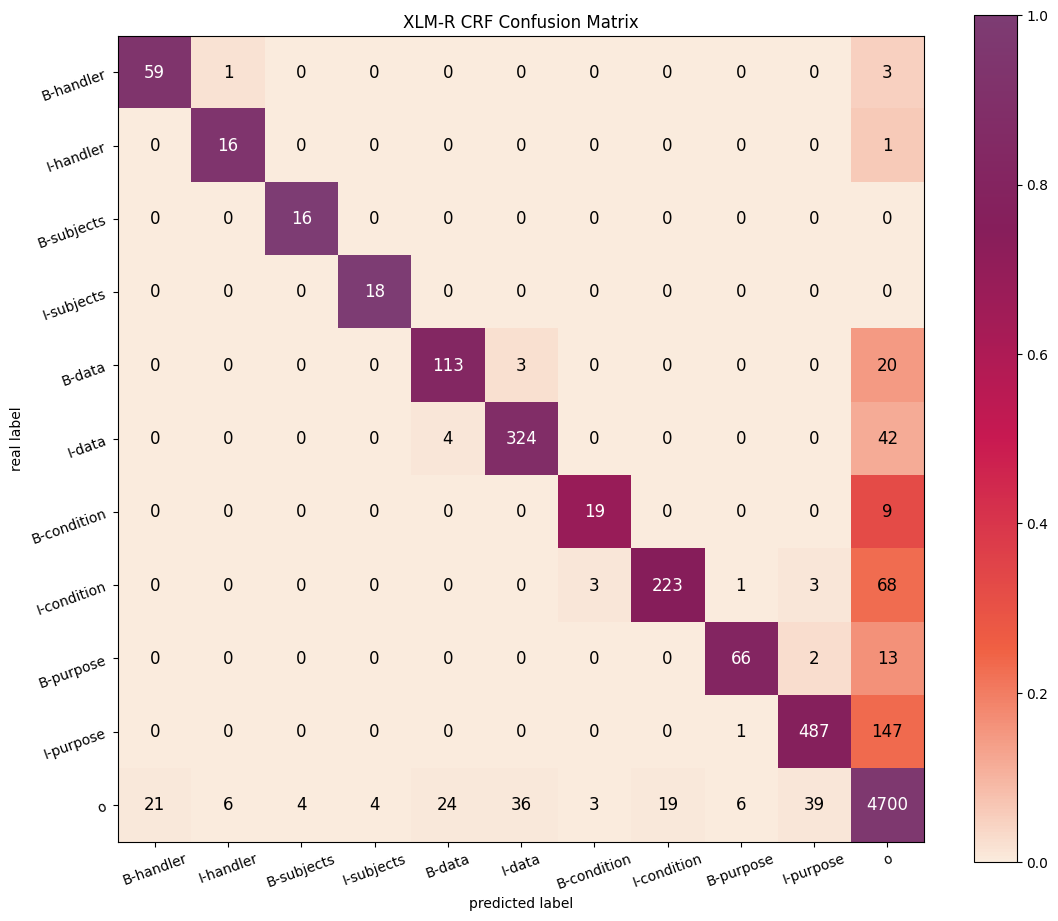

In [62]:
#fewshot_  MBert_tokenizer
test_model_en(fewshot_model, testset, xlmr_tokenizer, crf)

In [50]:
torch.save(model.state_dict(),'/kaggle/working/XML_model_srl.pth')

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_config = AutoConfig.from_pretrained(
  "xlm-roberta-base",
  num_labels=tags.num_classes,
  id2label=index2tag,
  label2id=tag2index
)

model = (XLMRobertaForTokenClassification
         .from_pretrained("xlm-roberta-base", config=xlmr_config)
         .to(device))
model_srl = model
model_srl.load_state_dict(torch.load('/kaggle/input/model-test/XML_model_srl.pth'),strict=False)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['crf.start_transitions', 'crf.transitions', 'classifier.weight', 'crf.end_transitions', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [53]:
from copy import deepcopy
dic_template = {'source':'','segment idx':int,'category':{}}
index_list = []
with open(r"/kaggle/input/health-dataset/appleApp_seg_pps_classified.jsonl", "r", encoding="utf8") as f:
    for lines in jsonlines.Reader(f):
        if lines['category']['First Party Collection/Use'] == True or lines['category']['Data Retention'] == True or lines['category']['Third Party Sharing/Collection'] == True:
            dic = deepcopy(dic_template)
            dic['source'] = lines['meta']['source']
            dic['segment idx'] = lines['meta']['segment idx']
            dic['category'] = lines['category']
            index_list.append(dic)

In [26]:
index_list[0]

{'source': 'Home_Workout_Six_Pack_Abs.html',
 'segment idx': 1,
 'category': {'First Party Collection/Use': True,
  'Third Party Sharing/Collection': False,
  'Data Retention': False}}

In [36]:
lines

{'text': 'Standard & Poor’s is an approved rating agency under the Insurance (Prudential Supervision) Act 2010.',
 'meta': {'source': 'My_Southern_Cross.html',
  'segment idx': '3',
  'sentence idx': '4'}}

In [54]:
sen_list = []
with open(r"/kaggle/input/health-dataset/appleApp_sen_pps.jsonl", "r", encoding="utf8") as f:
    for lines in jsonlines.Reader(f):
        for index in index_list:
            if lines['meta']['source'] == index['source'] and lines['meta']['segment idx'] == str(index['segment idx']) :
                lines['category'] = index['category']
                sen_list.append(lines)

In [55]:
len(sen_list)

27229

In [30]:
def get_tag(token_list, tags, model, tokenizer):
    '''返回token list + tag list'''
    token = tokenizer(token_list, is_split_into_words = True, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(token.input_ids.to(device))
    logits = outputs.logits
    predictions = model.crf.decode(logits)
    preds = [tags.names[p] for p in predictions[0]]
    word_ids = token.word_ids()
    return merge_label(preds, word_ids, token_list)

def test_model_en(model, dataloader, xlmr_tokenizer, crf):
    preds_labels = []
    true_labels = []
    model.eval()
    for test in dataloader:
        token = xlmr_tokenizer(test['tokens'],is_split_into_words = True,return_tensors="pt")
        with torch.no_grad():
            outputs = model(token.input_ids.to(device) )
        logits = outputs.logits
        if crf:
            predictions = model.crf.decode(logits)
        else:
            predictions = outputs.logits.argmax(dim=-1)
        preds = [tags.names[p] for p in predictions[0]] 
        word_ids = token.word_ids()
        preds_labels.append(merge_label(preds, word_ids, test['tokens']))
        true_labels.append(test['ner_tags'])
        
    metrics = Metrics(true_labels, preds_labels, remove_O=False)
    metrics.report_scores()
    metrics.report_confusion_matrix()
    metrics.draw_confusion_matrix()

In [57]:
json_lines = []
nlp = spacy.load("en_core_web_sm")

# progress_bar = tqdm(range(sen_list))
for sen in sen_list:
    doc = nlp(sen['text'])

    tokens = []
    for i, token in enumerate(doc):
        tokens.append({
            "text": token.text,
            "start": token.idx,
            "end": token.idx + len(token),
            "id": i,
            "ws": token.whitespace_ != ""
        })

    words = [token.text for token in doc if not token.text.isspace()]
    bio_tags = get_tag(words, tags, model_srl, xlmr_tokenizer)
    # 获取每个单词的偏移量
    offsets = []
    start = 0
    for token in doc:
        end = start + len(token)
        offsets.append((start, end))
        start = end

    # 将 BIO 标签转换为偏移量格式的 NER 标注
    entities = []
    entity_start = None
    entity_end = None
    entity_label = None
    token_start = None
    token_end = None
    for i, (tag, (start, end)) in enumerate(zip(bio_tags, offsets)):
        if tag.startswith("B-"):
            if entity_start is not None:
                entities.append({
                    "start": entity_start,
                    "end": entity_end,
                    "token_start": token_start,
                    "token_end": token_end,
                    "label": entity_label
                })
            entity_start = start
            entity_end = end
            token_start = i
            token_end = i
            entity_label = tag[2:]
        elif tag.startswith("I-"):
            if entity_start is not None and entity_label == tag[2:]:#当之前的start不是空，且
                entity_end = end
                token_end = i
            else:
                if entity_start is not None:
                    entities.append({
                        "start": entity_start,
                        "end": entity_end,
                        "token_start": token_start,
                        "token_end": token_end,
                        "label": entity_label
                    })
                entity_start = start
                entity_end = end
                token_start = i
                token_end = i
                entity_label = tag[2:]
        else:
            if entity_start is not None:
                entities.append({
                    "start": entity_start,
                    "end": entity_end,
                    "token_start": token_start,
                    "token_end": token_end,
                    "label": entity_label
                })
            entity_start = None
            entity_end = None
            token_start = None
            token_end = None
            entity_label = None

    if entity_start is not None:
        entities.append({
            "start": entity_start,
            "end": entity_end,
            "token_start": token_start,
            "token_end": token_end,
            "label": entity_label
        })
#     dic = deepcopy(dic_template)
#     dic['text'] = text
    sen['tokens'] = tokens
    sen['spans'] = entities
    json_lines.append(sen)

In [60]:
new = []
for jsonl in json_lines:
    jsonl['meta']['First Party Collection/Use'] = jsonl['category']['First Party Collection/Use']
    jsonl['meta']['Third Party Sharing/Collection'] = jsonl['category']['Third Party Sharing/Collection']
    jsonl['meta']['Data Retention'] = jsonl['category']['Data Retention']
    del jsonl['category']
    new.append(jsonl)

In [61]:
with jsonlines.open('/kaggle/working/appleApp_seg_pps_SRLed.jsonl', mode='w') as writer:
    writer.write_all(new)

In [62]:
json_lines[0]

{'text': 'our adherence with privacy requirements, including privacy laws, contractual agreements, and our policies and standards;',
 'meta': {'source': 'nib_Health.html',
  'segment idx': '5',
  'sentence idx': '0',
  'First Party Collection/Use': True,
  'Third Party Sharing/Collection': False,
  'Data Retention': False},
 'tokens': [{'text': 'our', 'start': 0, 'end': 3, 'id': 0, 'ws': True},
  {'text': 'adherence', 'start': 4, 'end': 13, 'id': 1, 'ws': True},
  {'text': 'with', 'start': 14, 'end': 18, 'id': 2, 'ws': True},
  {'text': 'privacy', 'start': 19, 'end': 26, 'id': 3, 'ws': True},
  {'text': 'requirements', 'start': 27, 'end': 39, 'id': 4, 'ws': False},
  {'text': ',', 'start': 39, 'end': 40, 'id': 5, 'ws': True},
  {'text': 'including', 'start': 41, 'end': 50, 'id': 6, 'ws': True},
  {'text': 'privacy', 'start': 51, 'end': 58, 'id': 7, 'ws': True},
  {'text': 'laws', 'start': 59, 'end': 63, 'id': 8, 'ws': False},
  {'text': ',', 'start': 63, 'end': 64, 'id': 9, 'ws': True}

In [12]:
tmp_list = []
with open(r"/kaggle/input/health-dataset/appleApp_seg_pps_SRLed.jsonl", "r", encoding="utf8") as f:
    for json in jsonlines.Reader(f):
        if len(json['spans']) >= 5 :
            flag1 = False
            flag2 = False
            flag3 = False
            for span in json['spans']:
                if span['label'] == 'condition':
                    flag1 = True
                if span['label'] == 'purpose':
                    flag2 = True
                if span['label'] == 'subjects':
                    flag3 = True
            if flag1 and flag2 and flag3:
                tmp_list.append(json)
#                 print(json['spans'])
#                 print(json['meta'])

In [13]:
len(tmp_list)

63

In [14]:
with jsonlines.open('/kaggle/working/appleApp_pps_SRLed_final.jsonl', mode='w') as writer:
    writer.write_all(tmp_list)

In [ ]:
#要给prodic的格式
dic_template = {'text': '', 
                'meta': {'source': '', 'segment idx': '','sentence idx':''},
                'category':{'First Party Collection/Use':bool,'Third Party Sharing/Collection':bool, 'Data Retention':bool},
                'Semantic Role':{'handler':[],'subjects':[],'data':[],'condition':[],'purpose':[]}}

In [ ]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink
FileLink('output.zip')

In [ ]:
#crf only
test_model_en(fewshot_model, testset, xlmr_tokenizer)

In [ ]:
def get_tag(token_list, tags, model, tokenizer):
    '''返回token list + tag list'''
    token = tokenizer(token_list, is_split_into_words = True, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(token.input_ids.to(device))
    logits = outputs.logits
    predictions = model.crf.decode(logits)
    preds = [tags.names[p] for p in predictions[0]]
    word_ids = token.word_ids()
    return merge_label(preds, word_ids, token_list)
# for sen in testset:
#     get_tag(sen, tags, fewshot_model, xlmr_tokenizer)

In [ ]:
testset[3].split(' ')

In [ ]:
len(testset)

In [ ]:
testset[0]

In [ ]:
def test_model_cn(model, dataloader):
    preds_labels = []
    true_labels = []
    model.eval()
    for test in dataloader:
        input_ids = torch.tensor([test['input_ids']])
#         print(input_ids.shape)
        with torch.no_grad():
            output = model(input_ids.to(device))
        logits = output.logits
#         print(logits.shape)
        predictions = model.crf.decode(logits)
#         print(len(predictions[0]))
        preds = [tags.names[p] for p in predictions[0]]
#         print(preds)
#         print(len(preds))
#         print(len(test['labels']))
        preds_labels.append(preds)
        labels = [tags.names[p] for p in test['labels']]
        true_labels.append(labels)
       
        assert len(preds) == len(test['labels'])
    metrics = Metrics(true_labels, preds_labels, remove_O=False)
    metrics.report_scores()
    metrics.report_confusion_matrix()
        

In [ ]:
test_model_cn(model, tokenized_ds['test'])

In [ ]:
test = xlmr_tokenizer(testset[0]['tokens'],is_split_into_words = True,return_tensors="pt")
test.word_ids()

In [ ]:
test_model_en(model, en_testset, xlmr_tokenizer)

In [ ]:
en_testset[21]['tokens']

In [ ]:
len(true_labels[0])

In [ ]:
tokenized_ds

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def tag_text_crf(text, tags, model, tokenizer):
	# Get tokens with special characters 
    tokens = tokenizer(text).tokens() 
	# Encode the sequence into IDs 
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device) 
	# Get predictions as distribution over 7 possible classes 
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    predictions = model.crf.decode(logits)
#     print(predictions[0])
# 	outputs = model(input_ids)[0] 
	# Take argmax to get most likely class per token 
# 	predictions = torch.argmax(outputs, dim=2) 
	# Convert to DataFrame 
    preds = [tags.names[p] for p in predictions[0]] 
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [ ]:
dic_template = {"text":"","tokens":[],"spans":[],"answer":"accept"}
json_lines = []
nlp = spacy.load("en_core_web_sm")


for text in testset:
    doc = nlp(text)

    tokens = []
    for i, token in enumerate(doc):
        tokens.append({
            "text": token.text,
            "start": token.idx,
            "end": token.idx + len(token),
            "id": i,
            "ws": token.whitespace_ != ""
        })

    words = [token.text for token in doc]
    bio_tags = get_tag(words, tags, fewshot_model, xlmr_tokenizer)
    # 获取每个单词的偏移量
    offsets = []
    start = 0
    for token in doc:
        end = start + len(token)
        offsets.append((start, end))
        start = end

    # 将 BIO 标签转换为偏移量格式的 NER 标注
    entities = []
    entity_start = None
    entity_end = None
    entity_label = None
    token_start = None
    token_end = None
    for i, (tag, (start, end)) in enumerate(zip(bio_tags, offsets)):
        if tag.startswith("B-"):
            if entity_start is not None:
                entities.append({
                    "start": entity_start,
                    "end": entity_end,
                    "token_start": token_start,
                    "token_end": token_end,
                    "label": entity_label
                })
            entity_start = start
            entity_end = end
            token_start = i
            token_end = i
            entity_label = tag[2:]
        elif tag.startswith("I-"):
            if entity_start is not None and entity_label == tag[2:]:#当之前的start不是空，且
                entity_end = end
                token_end = i
            else:
                if entity_start is not None:
                    entities.append({
                        "start": entity_start,
                        "end": entity_end,
                        "token_start": token_start,
                        "token_end": token_end,
                        "label": entity_label
                    })
                entity_start = start
                entity_end = end
                token_start = i
                token_end = i
                entity_label = tag[2:]
        else:
            if entity_start is not None:
                entities.append({
                    "start": entity_start,
                    "end": entity_end,
                    "token_start": token_start,
                    "token_end": token_end,
                    "label": entity_label
                })
            entity_start = None
            entity_end = None
            token_start = None
            token_end = None
            entity_label = None

    if entity_start is not None:
        entities.append({
            "start": entity_start,
            "end": entity_end,
            "token_start": token_start,
            "token_end": token_end,
            "label": entity_label
        })
    dic = deepcopy(dic_template)
    dic['text'] = text
    dic['tokens'] = tokens
    dic['spans'] = entities
    json_lines.append(dic)

In [ ]:
doc = nlp(testset[3])
test = get_tag(testset[3], tags, fewshot_model, xlmr_tokenizer)
offsets = []
start = 0
for token in doc:
    end = start + len(token)
    offsets.append((start, end))
    start = end
offsets